<a href="https://colab.research.google.com/github/Wanita-8943/efficientnet_keras_transfer_learning/blob/master/4_4_%E0%B8%A3%E0%B8%AD%E0%B8%9A%E0%B8%97%E0%B8%B5%E0%B9%884_Train_Female125_250.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [4]:
batch_size = 16
width = 150
height = 150
epochs = 250
NUM_TRAIN = 1425
NUM_TEST = 473
dropout_rate = 0.2
input_shape = (height, width, 3)

In [5]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 581, done.
remote: Counting objects: 100% (397/397), done.
remote: Compressing objects: 100% (198/198), done.
remote: Total 581 (delta 275), reused 266 (delta 199), pack-reused 184
Receiving objects: 100% (581/581), 10.76 MiB | 17.82 MiB/s, done.
Resolving deltas: 100% (348/348), done.
/content/efficientnet_keras_transfer_learning


In [6]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [7]:
base_dir = '/content/drive/MyDrive/TVT_Female125'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

#load model

In [8]:
import sys
sys.path.append('/content/drive/MyDrive/cut_panoramic/Model/3.3_รอบที่3_Flimpano_Female125_250.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [9]:
#load model 
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/cut_panoramic/Model/3.3_รอบที่3_Flimpano_Female125_250.h5')
height = width = model.input_shape[1]

In [10]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 19)                24339     
                                                                 
Total params: 4,073,903
Trainable params: 24,339
Non-trainable params: 4,049,564
_________________________________________________________________


In [11]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory #ไดเรกเป้าหมาย
        train_dir,
        # รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        #เนื่องจากเราใช้ categorical_crossentropy loss เราจึงต้องมีป้ายกำกับตามหมวดหมู่
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory( #การดึงภาพจาก Directory มาเข้าโมเดล 
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 1425 images belonging to 19 classes.
Found 475 images belonging to 19 classes.


In [12]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-12-caa7b37242a8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/250
89/89 [==============================] - 342s 4s/step - loss: 2.2531 - acc: 0.2548 - val_loss: 2.7265 - val_acc: 0.1810
Epoch 2/250
89/89 [==============================] - 70s 769ms/step - loss: 2.2710 - acc: 0.2541 - val_loss: 2.7320 - val_acc: 0.1767
Epoch 3/250
89/89 [==============================] - 76s 820ms/step - loss: 2.2855 - acc: 0.2583 - val_loss: 2.7191 - val_acc: 0.1832
Epoch 4/250
89/89 [==============================] - 72s 791ms/step - loss: 2.2320 - acc: 0.2569 - val_loss: 2.7206 - val_acc: 0.1789
Epoch 5/250
89/89 [==============================] - 74s 808ms/step - loss: 2.2529 - acc: 0.2427 - val_loss: 2.7485 - val_acc: 0.1875
Epoch 6/250
89/89 [==============================] - 72s 784ms/step - loss: 2.2695 - acc: 0.2583 - val_loss: 2.7008 - val_acc: 0.1789
Epoch 7/250
89/89 [==============================] - 74s 809ms/step - loss: 2.2621 - acc: 0.2477 - val_loss: 2.7453 - val_acc: 0.1767
Epoch 8/250
89/89 [==============================] - 72s 787ms/s

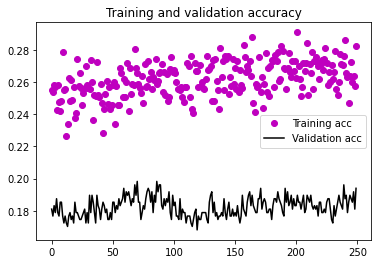

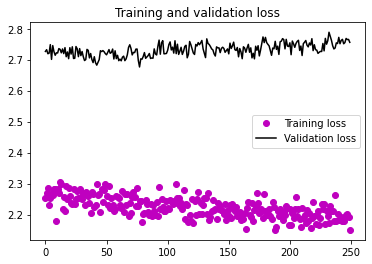

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'mo', label='Training acc')
plt.plot(epochs_x, val_acc, 'k', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'mo', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Download the model

In [14]:
os.makedirs('/content/drive/My Drive/cut_panoramic/Model', exist_ok=True)
model.save('/content/drive/My Drive/cut_panoramic/Model/4.4_รอบที่4_Flimpano_Female125_250.h5')

In [15]:
from google.colab import files
files.download('/content/drive/My Drive/cut_panoramic/Model/4.4_รอบที่4_Flimpano_Female125_250.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>